In [1]:
# https://quantumcomputing.stackexchange.com/questions/24050/how-to-implement-a-exponential-of-a-hamiltonian-but-non-unitary-matrix-in-qisk

# control gate: https://qiskit.org/documentation/stubs/qiskit.circuit.ControlledGate.html

# circuit https://www.nature.com/articles/s41598-022-17660-8
import numpy as np
from sklearn.preprocessing import normalize

from qiskit.circuit import ControlledGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.tools.visualization import plot_histogram

from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow.list_ops import SummedOp
from qiskit.circuit import Parameter
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp

In [4]:
A = np.array([[ 1.09348182,  0.01643946, -0.01384925, -0.01213564], [ 0.01643946,  1.05659253,  0.04265326,  0.01915678], [-0.01384925,  0.04265326,  1.03990905,  0.01967412], [-0.01213564,  0.01915678,  0.01967412,  1.01001659]]).astype('complex')

# A = np.array([[ 0.6201803 , -0.0884858 ,  0.06018728, -0.47339672],
#               [-0.0884858 ,  0.97938565,  0.0140217 , -0.11028624],
#               [ 0.06018728,  0.0140217 ,  0.99046256,  0.07501575],
#               [-0.47339672, -0.11028624,  0.07501575,  0.4099715 ]]).astype('complex')
# A = np.array([[ 1.20061653,  0.37361167,  0.2394791 ,  0.39870151],
#               [ 0.37361167,  2.43936584,  0.75247403, -0.17244919],
#               [ 0.2394791 ,  0.75247403,  3.25826483, -0.48329325],
#               [ 0.39870151, -0.17244919, -0.48329325,  3.1017528 ]]).astype('complex')
# u, s, vh = np.linalg.svd(A, full_matrices=False)
# print(s)

b = np.array([np.sin(np.pi/4)**2, np.sin(np.pi/4)**2, np.sin(np.pi/4)**2, np.sin(np.pi/4)**2]).T
# b = np.array([0, 0, 0, 1]).T
x = np.linalg.solve(A, b)
print(x)

[0.4618471 +0.j 0.43870817+0.j 0.45982401+0.j 0.4833128 +0.j]


In [5]:
def get_gate(A, n):    
    pauli_op = PauliSumOp(SparsePauliOp.from_operator(A))
    phi = Parameter('ϕ')
    evolution_op = (phi * pauli_op).exp_i() # exp(-iϕA)
    trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evolution_op).bind_parameters({phi: np.pi/n})
    #----control---------
    gate = trotterized_op.to_circuit()
    # print(gate)
    gate.name = f"e^(i*A*pi/{n})"
    gate.label = f"e^(i*A*np.pi/{n})"
    gate = gate.to_gate().control()
    #---------------------
    return gate

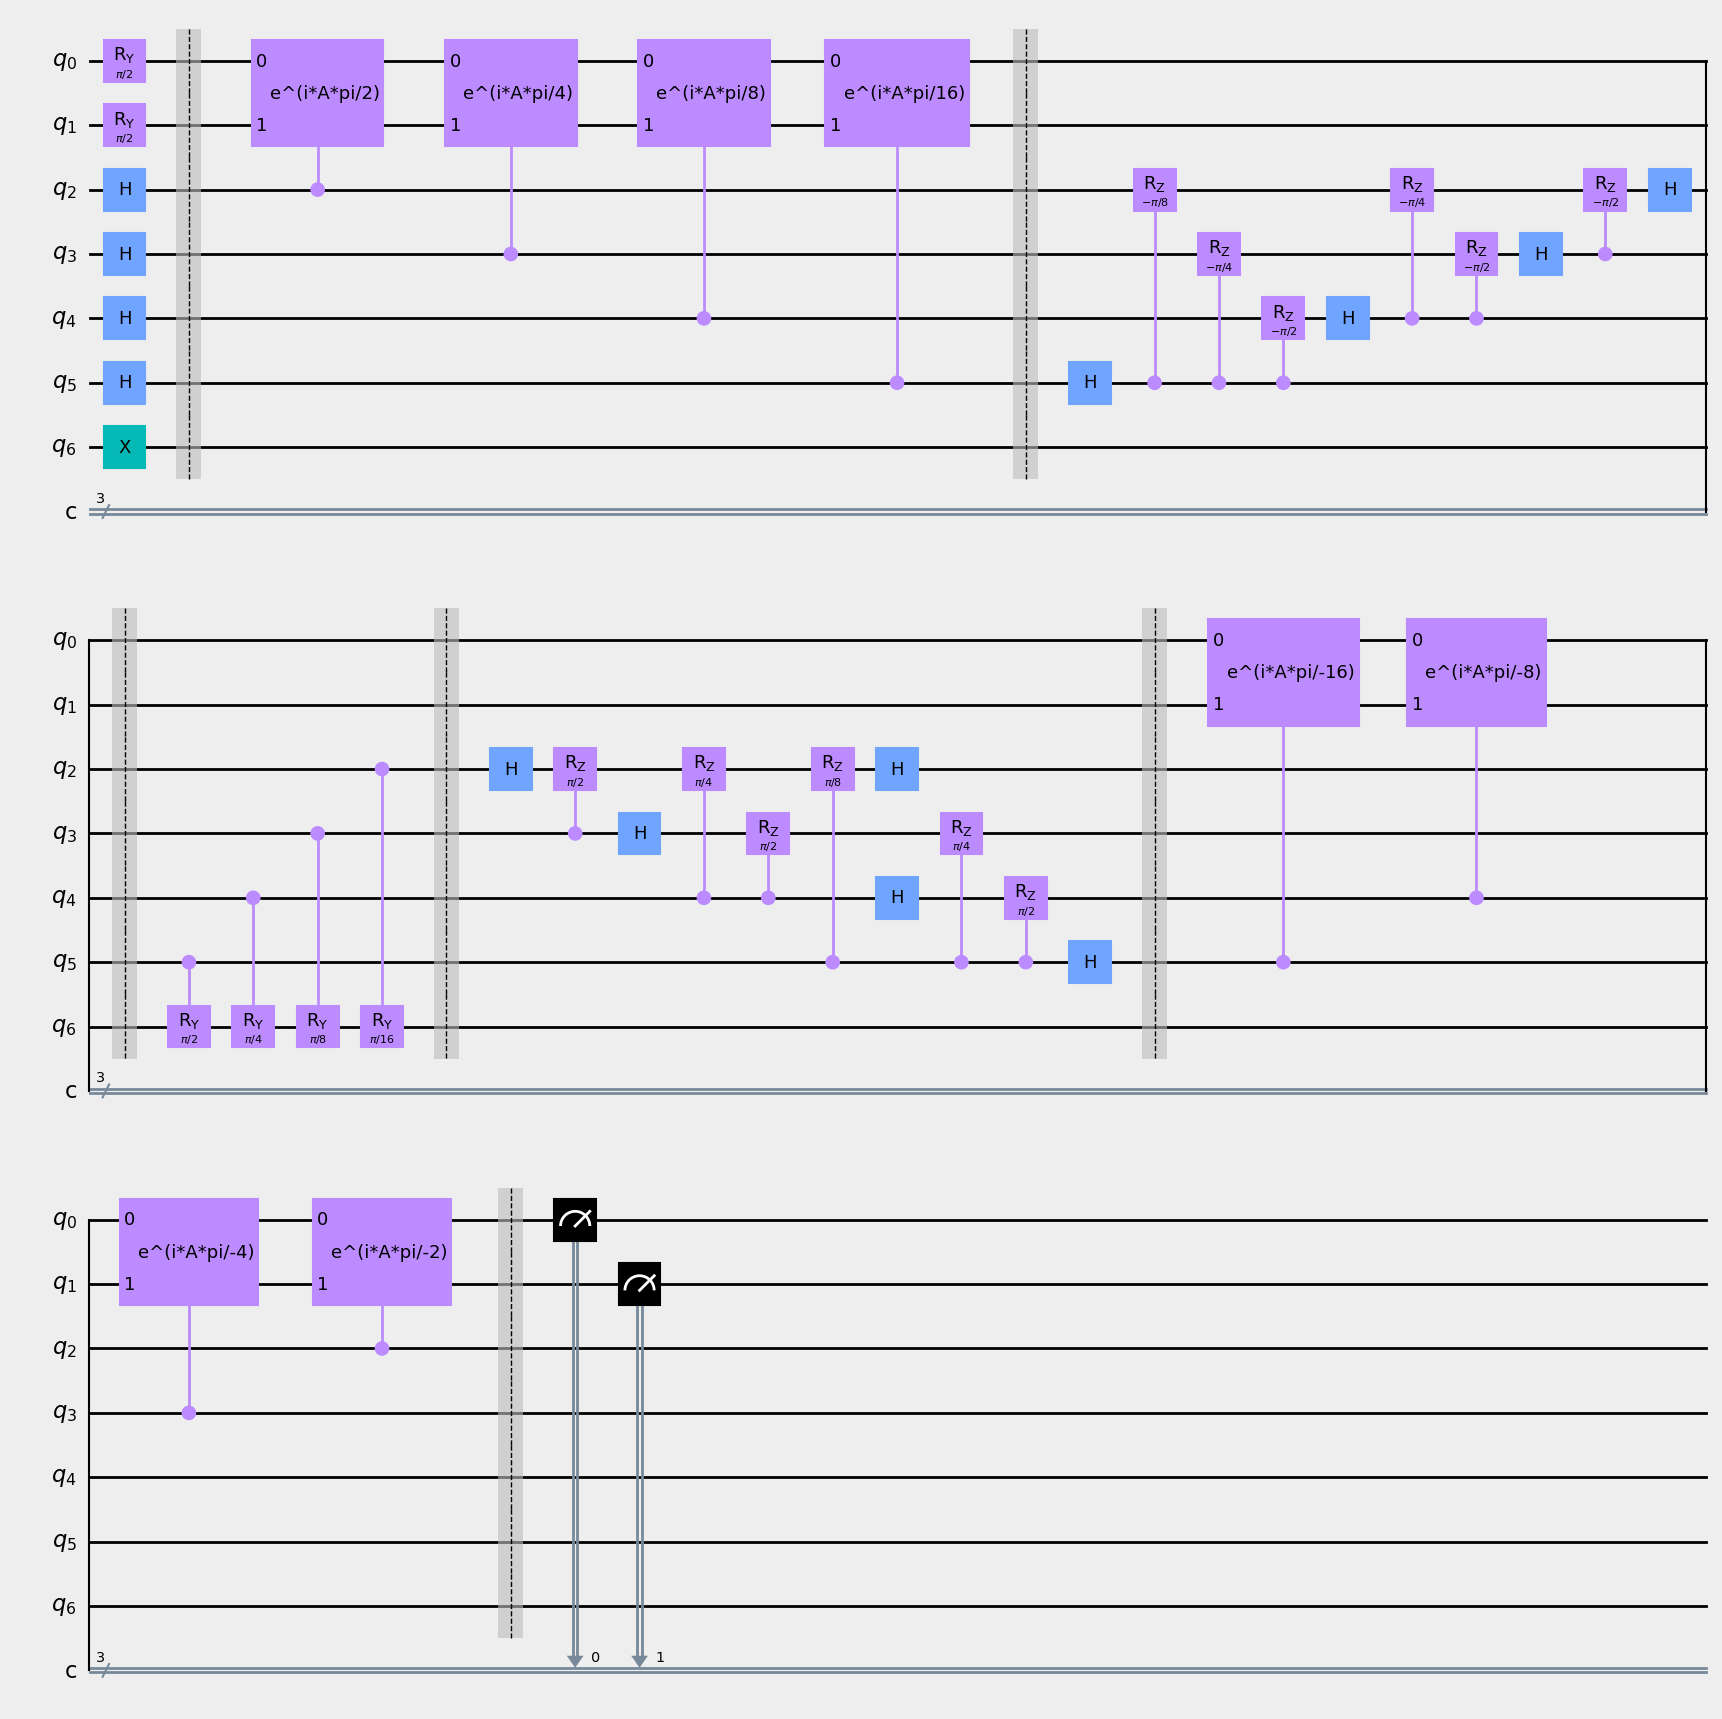

In [27]:
n_b = 2
n_ = 4 #3 is an optimal
n_ancilla = 1
n_cl = 3
# quantum circuit initialization
qc = QuantumCircuit(n_b + n_ + n_ancilla, n_cl)
# b-vector state preparation
for i in range(n_b):
    qc.ry(np.pi/2, i)
for i in range(n_b, n_b+n_):
    qc.h(i)
qc.x(-1)
qc.barrier()
# Matrix exponentiation
for i in range(1, n_+1):
    gate = get_gate(A, 2**(i))
    qc.append(gate,[i+1, 0, 1])
qc.barrier()
# Phase estimation
for j in range(n_b + n_ - 1, n_b, -1):
    qc.h(j)
    for m in range(j - n_b):
        qc.crz(-np.pi/float(2**(j-m - n_b)), j, m+n_b)
qc.h(j-1)
qc.barrier()
# As I understood, we wncode ancilla qubit to be sure that result will be correct
for j in range(1, 1+n_):
    qc.cry(np.pi/(2**j), n_b+n_-j, n_b+n_)
qc.barrier()
# Inverse quantum Fourier transform
for j in range(n_b, n_b + n_):
    for m in range(j - n_b):
        qc.crz(np.pi/float(2**(j-m - n_b)), j, m+n_b)
    qc.h(j)
qc.h(n_b)
qc.barrier()
# Eigenvalues storing in the vecor b register
for i in range(n_, 0, -1):
    gate = get_gate(A, -(2**(i)))
    qc.append(gate,[i+1, 0, 1], )
qc.barrier()
# qubits measurement. I do not measure the ancilla qubit
# qc.measure(-1, 3)
qc.measure(0, 0)
qc.measure(1, 1)
# qc.measure(2, 2)

qc.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})

In [28]:
simulator = Aer.get_backend('qasm_simulator')
circ = transpile(qc, simulator)
shots = 2048
result = execute(qc, backend=simulator, shots=shots).result()

# Calculated result

In [29]:
counts = result.get_counts()
probabilities = counts.copy()
for k, v in probabilities.items():
    probabilities[k] = v/shots
probabilities

{'010': 0.24072265625,
 '000': 0.24267578125,
 '011': 0.2490234375,
 '001': 0.267578125}

# Result vector

In [30]:
vect = np.array([v for k,v in probabilities.items()])
vect.sort()
np.round(vect, 5)

array([0.24072, 0.24268, 0.24902, 0.26758])

# Real normalized result

In [31]:
# a = [0.03125, -0.03125, 0.0625, 0.125] - original
a = [1.30630085, 1.24085408, 1.3005787, 1.36701502]

real_x_norm = (np.array(a) / np.linalg.norm(a))**2
real_x_norm.sort()
np.round(real_x_norm, 5)

array([0.22622, 0.24852, 0.25071, 0.27456])

# Error

In [32]:
mse = (np.square(vect - real_x_norm)).mean()
print(mse)
abs_err = np.mean([np.abs((v-r)/r) for v,r in zip(vect, real_x_norm)])
print(abs_err)

7.40171688338667e-05
0.029942044989493065
